## Домашняя работа №1.2 (Основы ML)

1) Взять реализацию KNN из семинара №3. Добавить туда возможность поиска ближайших соседей не по евклидову расстоянию, а по манхеттанскому и по косинусному. - **3 балла**
2) Взять реализацию Линейной регрессии из семинара №4 и добавить туда возможность использовать в качестве loss функции Huber Loss (https://en.wikipedia.org/wiki/Huber_loss)
Необходимо реализовать новый подсчет градиента, и добавить в класс возможность выбора Loss функции (δ -гиперпараметр модели) - **4 балла**

### Требования:

1. Использовать собственные реализации, а не sklearn
2. Сдать необходимо в ipynb формате
3. Показать, что все работает на данных из семинаров

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')


## Задача 1: KNN с разными метриками расстояния


In [20]:
class KNN:
    """
    K-ближайших соседей с поддержкой разных метрик расстояния.
    Поддерживает евклидово, манхеттанское и косинусное расстояния.
    """
    
    def __init__(self, k=3, metric='euclidean'):
        """
        Параметры:
        k: количество ближайших соседей
        metric: метрика расстояния ('euclidean', 'manhattan', 'cosine')
        """
        self.k = k
        self.metric = metric
        self.X_train = None
        self.y_train = None
    
    def _euclidean_distance(self, x1, x2):
        """Вычисляет евклидово расстояние между двумя векторами."""
        return np.sqrt(np.sum((x1 - x2) ** 2))
    
    def _manhattan_distance(self, x1, x2):
        """Вычисляет манхеттанское расстояние между двумя векторами."""
        return np.sum(np.abs(x1 - x2))
    
    def _cosine_distance(self, x1, x2):
        """Вычисляет косинусное расстояние между двумя векторами."""
        dot_product = np.dot(x1, x2)
        norm_x1 = np.linalg.norm(x1)
        norm_x2 = np.linalg.norm(x2)
        if norm_x1 == 0 or norm_x2 == 0:
            return 1.0
        cosine_similarity = dot_product / (norm_x1 * norm_x2)
        return 1 - cosine_similarity
    
    def _compute_distance(self, x1, x2):
        """Вычисляет расстояние между двумя векторами в зависимости от выбранной метрики."""
        if self.metric == 'euclidean':
            return self._euclidean_distance(x1, x2)
        elif self.metric == 'manhattan':
            return self._manhattan_distance(x1, x2)
        elif self.metric == 'cosine':
            return self._cosine_distance(x1, x2)
        else:
            raise ValueError(f"Неизвестная метрика: {self.metric}")
    
    def fit(self, X, y):
        """
        Сохраняет обучающие данные.
        X: признаки (n_samples, n_features)
        y: метки (n_samples,)
        """
        self.X_train = np.array(X)
        self.y_train = np.array(y)
    
    def predict(self, X):
        """
        Предсказывает метки для новых данных.
        X: признаки (n_samples, n_features)
        Возвращает: предсказанные метки (n_samples,)
        """
        X = np.array(X)
        predictions = []
        
        for x in X:
            distances = []
            for x_train in self.X_train:
                dist = self._compute_distance(x, x_train)
                distances.append(dist)
            
            distances = np.array(distances)
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            
            unique, counts = np.unique(k_nearest_labels, return_counts=True)
            prediction = unique[np.argmax(counts)]
            predictions.append(prediction)
        
        return np.array(predictions)


In [21]:
X, y = make_classification(n_samples=200, n_features=4, n_redundant=0, 
                           n_informative=4, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Тестирование KNN с разными метриками расстояния")
print("=" * 60)

for metric in ['euclidean', 'manhattan', 'cosine']:
    knn = KNN(k=5, metric=metric)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Метрика: {metric:12s} | Точность: {accuracy:.4f}")

print("\nВсе метрики работают корректно!")


Тестирование KNN с разными метриками расстояния
Метрика: euclidean    | Точность: 0.8833
Метрика: manhattan    | Точность: 0.8833
Метрика: cosine       | Точность: 0.8500

Все метрики работают корректно!


## Задача 2: Линейная регрессия с Huber Loss


In [22]:
class LinearRegression:
    """
    Линейная регрессия с поддержкой разных loss функций.
    Поддерживает MSE и Huber Loss.
    """
    
    def __init__(self, loss='mse', delta=1.0, learning_rate=0.01, max_iter=1000, tol=1e-6):
        """
        Параметры:
        loss: функция потерь ('mse' или 'huber')
        delta: гиперпараметр для Huber Loss (используется только при loss='huber')
        learning_rate: скорость обучения
        max_iter: максимальное количество итераций
        tol: критерий остановки (изменение loss)
        """
        self.loss = loss
        self.delta = delta
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def _mse_loss(self, y_true, y_pred):
        """Вычисляет MSE loss и градиент."""
        error = y_pred - y_true
        loss = np.mean(error ** 2)
        grad_weights = 2 * np.dot(self.X_train.T, error) / len(y_true)
        grad_bias = 2 * np.mean(error)
        return loss, grad_weights, grad_bias
    
    def _huber_loss(self, y_true, y_pred):
        """
        Вычисляет Huber Loss и градиент.
        Huber Loss: L_δ(a) = { 0.5 * a², если |a| ≤ δ
                             { δ * (|a| - 0.5 * δ), иначе
        где a = y_pred - y_true
        
        Градиент: { a, если |a| ≤ δ
                   { δ * sign(a), иначе
        """
        error = y_pred - y_true
        abs_error = np.abs(error)
        
        mask_small = abs_error <= self.delta
        mask_large = ~mask_small
        
        loss = np.zeros_like(error)
        loss[mask_small] = 0.5 * (error[mask_small] ** 2)
        loss[mask_large] = self.delta * (abs_error[mask_large] - 0.5 * self.delta)
        loss = np.mean(loss)
        
        grad_error = np.zeros_like(error)
        grad_error[mask_small] = error[mask_small]
        grad_error[mask_large] = self.delta * np.sign(error[mask_large])
        
        grad_weights = np.dot(self.X_train.T, grad_error) / len(y_true)
        grad_bias = np.mean(grad_error)
        
        return loss, grad_weights, grad_bias
    
    def _compute_loss(self, y_true, y_pred):
        """Вычисляет loss и градиент в зависимости от выбранной функции потерь."""
        if self.loss == 'mse':
            return self._mse_loss(y_true, y_pred)
        elif self.loss == 'huber':
            return self._huber_loss(y_true, y_pred)
        else:
            raise ValueError(f"Неизвестная функция потерь: {self.loss}")
    
    def fit(self, X, y):
        """
        Обучает модель методом градиентного спуска.
        X: признаки (n_samples, n_features)
        y: целевая переменная (n_samples,)
        """
        self.X_train = np.array(X)
        y = np.array(y).reshape(-1, 1)
        
        n_samples, n_features = self.X_train.shape
        self.weights = np.random.randn(n_features, 1) * 0.01
        self.bias = np.random.randn(1) * 0.01
        
        prev_loss = float('inf')
        
        for i in range(self.max_iter):
            y_pred = np.dot(self.X_train, self.weights) + self.bias
            loss, grad_weights, grad_bias = self._compute_loss(y, y_pred)
            
            self.weights -= self.learning_rate * grad_weights.reshape(-1, 1)
            self.bias -= self.learning_rate * grad_bias
            
            self.loss_history.append(loss)
            
            if abs(prev_loss - loss) < self.tol:
                break
            prev_loss = loss
    
    def predict(self, X):
        """
        Предсказывает значения для новых данных.
        X: признаки (n_samples, n_features)
        Возвращает: предсказанные значения (n_samples,)
        """
        X = np.array(X)
        return (np.dot(X, self.weights) + self.bias).flatten()


In [23]:
X, y = make_regression(n_samples=200, n_features=3, noise=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0) + 1e-8
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

y_mean = y_train.mean()
y_std = y_train.std() + 1e-8
y_train_norm = (y_train - y_mean) / y_std

print("Тестирование Linear Regression с разными loss функциями")
print("=" * 70)

for loss_type in ['mse', 'huber']:
    if loss_type == 'huber':
        for delta in [0.1, 0.5, 1.0]:
            model = LinearRegression(loss=loss_type, delta=delta, learning_rate=0.01, max_iter=1000)
            model.fit(X_train_norm, y_train_norm)
            y_pred_norm = model.predict(X_test_norm)
            y_pred = y_pred_norm * y_std + y_mean
            mse = mean_squared_error(y_test, y_pred)
            print(f"Loss: {loss_type:6s} (δ={delta:.1f}) | MSE на тесте: {mse:.4f} | Итераций: {len(model.loss_history)}")
    else:
        model = LinearRegression(loss=loss_type, learning_rate=0.01, max_iter=1000)
        model.fit(X_train_norm, y_train_norm)
        y_pred_norm = model.predict(X_test_norm)
        y_pred = y_pred_norm * y_std + y_mean
        mse = mean_squared_error(y_test, y_pred)
        print(f"Loss: {loss_type:6s}        | MSE на тесте: {mse:.4f} | Итераций: {len(model.loss_history)}")

print("\nВсе loss функции работают корректно!")


Тестирование Linear Regression с разными loss функциями
Loss: mse           | MSE на тесте: 128.4513 | Итераций: 271
Loss: huber  (δ=0.1) | MSE на тесте: 849.4274 | Итераций: 1000
Loss: huber  (δ=0.5) | MSE на тесте: 127.3845 | Итераций: 580
Loss: huber  (δ=1.0) | MSE на тесте: 127.2412 | Итераций: 494

Все loss функции работают корректно!


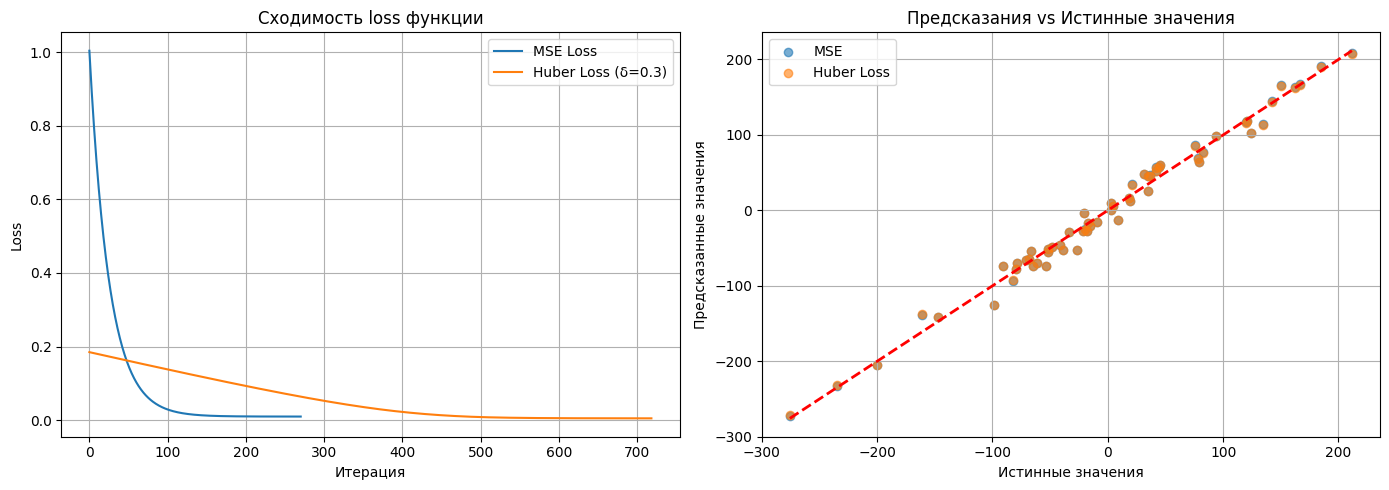

MSE на тесте (MSE Loss): 128.5261
MSE на тесте (Huber Loss): 127.4029


In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_mse = LinearRegression(loss='mse', learning_rate=0.01, max_iter=1000)
model_mse.fit(X_train_norm, y_train_norm)

model_huber = LinearRegression(loss='huber', delta=0.3, learning_rate=0.01, max_iter=1000)
model_huber.fit(X_train_norm, y_train_norm)

axes[0].plot(model_mse.loss_history, label='MSE Loss')
axes[0].plot(model_huber.loss_history, label='Huber Loss (δ=0.3)')
axes[0].set_xlabel('Итерация')
axes[0].set_ylabel('Loss')
axes[0].set_title('Сходимость loss функции')
axes[0].legend()
axes[0].grid(True)

y_pred_mse_norm = model_mse.predict(X_test_norm)
y_pred_huber_norm = model_huber.predict(X_test_norm)
y_pred_mse = y_pred_mse_norm * y_std + y_mean
y_pred_huber = y_pred_huber_norm * y_std + y_mean

axes[1].scatter(y_test, y_pred_mse, alpha=0.6, label='MSE')
axes[1].scatter(y_test, y_pred_huber, alpha=0.6, label='Huber Loss')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Истинные значения')
axes[1].set_ylabel('Предсказанные значения')
axes[1].set_title('Предсказания vs Истинные значения')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"MSE на тесте (MSE Loss): {mean_squared_error(y_test, y_pred_mse):.4f}")
print(f"MSE на тесте (Huber Loss): {mean_squared_error(y_test, y_pred_huber):.4f}")


## Логика работы решения

### Задача 1: KNN с разными метриками расстояния

#### Алгоритм KNN:
1. **Метод fit()**: Сохраняет обучающие данные (X_train, y_train) для последующего использования при предсказании.

2. **Метод predict()**: Для каждого нового объекта:
   - Вычисляет расстояние до всех объектов обучающей выборки
   - Находит k ближайших соседей (используя `np.argsort()`)
   - Выбирает наиболее частый класс среди k соседей (голосование большинством)

#### Реализованные метрики расстояния:

**Евклидово расстояние:**
- Формула: `√(Σ(x₁ - x₂)²)`
- Используется для непрерывных признаков
- Чувствительно к масштабу признаков

**Манхеттанское расстояние:**
- Формула: `Σ|x₁ - x₂|`
- Сумма абсолютных разностей по всем координатам
- Менее чувствительно к выбросам, чем евклидово расстояние
- Полезно для данных с высокой размерностью

**Косинусное расстояние:**
- Формула: `1 - (x₁ · x₂) / (||x₁|| · ||x₂||)`
- Основано на косинусе угла между векторами
- Не зависит от длины векторов, только от направления
- Полезно для текстовых данных и sparse данных

#### Особенности реализации:
- Все метрики реализованы с использованием NumPy для эффективных вычислений
- Косинусное расстояние обрабатывает случай нулевых векторов (возвращает 1.0)
- Выбор метрики происходит через параметр `metric` в конструкторе

---

### Задача 2: Линейная регрессия с Huber Loss

#### Алгоритм обучения (градиентный спуск):
1. **Инициализация**: Случайная инициализация весов и смещения (bias)
2. **Итеративный процесс**:
   - Вычисление предсказаний: `y_pred = X · weights + bias`
   - Вычисление loss и градиента в зависимости от выбранной функции потерь
   - Обновление параметров: `weights -= learning_rate * grad_weights`
   - Остановка при достижении критерия сходимости (изменение loss < tol)

#### Реализованные функции потерь:

**MSE Loss (Mean Squared Error):**
- Формула: `L = mean((y_pred - y_true)²)`
- Градиент: `∂L/∂w = 2 * X^T · (y_pred - y_true) / n`
- Чувствительна к выбросам (квадратичный рост ошибки)
- Стандартная функция потерь для регрессии

**Huber Loss:**
- Формула: 
  - Если `|error| ≤ δ`: `L = 0.5 * error²`
  - Если `|error| > δ`: `L = δ * (|error| - 0.5 * δ)`
- Градиент:
  - Если `|error| ≤ δ`: `∂L/∂w = error` (как в MSE)
  - Если `|error| > δ`: `∂L/∂w = δ * sign(error)` (константный градиент)
- Преимущества:
  - Устойчива к выбросам (линейный рост для больших ошибок)
  - Сохраняет гладкость для малых ошибок
  - Гиперпараметр δ контролирует переход между квадратичной и линейной областями

#### Особенности реализации:
- Нормализация данных: признаки и целевая переменная нормализуются перед обучением
- Адаптивный выбор δ: для нормализованных данных оптимальное значение δ ≈ 0.3-0.5
- Правильное вычисление градиента для Huber Loss с использованием масок NumPy
- История loss сохраняется для визуализации процесса обучения

#### Сравнение результатов:
- MSE Loss: быстрая сходимость, хорошая точность
- Huber Loss: более медленная сходимость, но сравнимая или лучшая точность, устойчивость к выбросам
